In [1]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import re
from spacy.lang.en.stop_words import STOP_WORDS as stopWords
import spacy
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBRFClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
import optuna
import pickle
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
import joblib

c:\Users\MEHMET\Desktop\nlp_project\nlpenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
raw_df = pd.read_csv("datasets\Sentences_50Agree.txt", 
                     encoding="latin1",sep="@", header=None, 
                     names=["text","label_name"])

print(raw_df)

                                                   text label_name
0     According to Gran , the company has no plans t...    neutral
1     Technopolis plans to develop in stages an area...    neutral
2     The international electronic industry company ...   negative
3     With the new production plant the company woul...   positive
4     According to the company 's updated strategy f...   positive
...                                                 ...        ...
4841  LONDON MarketWatch -- Share prices ended lower...   negative
4842  Rinkuskiai 's beer sales fell by 6.5 per cent ...    neutral
4843  Operating profit fell to EUR 35.4 mn from EUR ...   negative
4844  Net sales of the Paper segment decreased to EU...   negative
4845  Sales in Finland decreased by 10.5 % in Januar...   negative

[4846 rows x 2 columns]


<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\MEHMET\AppData\Local\Temp\ipykernel_13972\2654664111.py:1: SyntaxWarning: invalid escape sequence '\S'
  raw_df = pd.read_csv("datasets\Sentences_50Agree.txt",


In [4]:
df = raw_df.copy()

In [5]:
df["label_name"].value_counts()

label_name
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64

In [6]:
df["text"] = df["text"].str.lower()
print(df)

                                                   text label_name
0     according to gran , the company has no plans t...    neutral
1     technopolis plans to develop in stages an area...    neutral
2     the international electronic industry company ...   negative
3     with the new production plant the company woul...   positive
4     according to the company 's updated strategy f...   positive
...                                                 ...        ...
4841  london marketwatch -- share prices ended lower...   negative
4842  rinkuskiai 's beer sales fell by 6.5 per cent ...    neutral
4843  operating profit fell to eur 35.4 mn from eur ...   negative
4844  net sales of the paper segment decreased to eu...   negative
4845  sales in finland decreased by 10.5 % in januar...   negative

[4846 rows x 2 columns]


In [7]:
df["text"] = df["text"].apply(lambda x: re.sub(r"(?<!\d)[.,;:](?!\d)", "", x)) #This code protects punctuation between numbers
df["text"] = df["text"].apply(lambda x: re.sub(r"\b(\d+(\.\d+)?%?)\b", r"\1", x)) #This code protects percents and decimals

In [8]:
nlp = spacy.load("en_core_web_sm")

In [9]:
df["text"] = df["text"].apply(lambda x:
                               " ".join([word.text for word in nlp(x) 
                                         if word.text.lower() not in stopWords and len(word.text) > 1]))

In [10]:
df["text"]

0       according gran company plans production russia...
1       technopolis plans develop stages area 100,000 ...
2       international electronic industry company elco...
3       new production plant company increase capacity...
4       according company updated strategy years 2009 ...
                              ...                        
4841    london marketwatch -- share prices ended lower...
4842    rinkuskiai beer sales fell 6.5 cent 4.16 milli...
4843    operating profit fell eur 35.4 mn eur 68.8 mn ...
4844    net sales paper segment decreased eur 221.6 mn...
4845    sales finland decreased 10.5 january sales out...
Name: text, Length: 4846, dtype: object

In [11]:
df["text"] = df["text"].str.strip()

In [12]:
df["text"] = df["text"].str.replace(r"\s+", " ", regex=True)

In [13]:
df["text"]

0       according gran company plans production russia...
1       technopolis plans develop stages area 100,000 ...
2       international electronic industry company elco...
3       new production plant company increase capacity...
4       according company updated strategy years 2009 ...
                              ...                        
4841    london marketwatch -- share prices ended lower...
4842    rinkuskiai beer sales fell 6.5 cent 4.16 milli...
4843    operating profit fell eur 35.4 mn eur 68.8 mn ...
4844    net sales paper segment decreased eur 221.6 mn...
4845    sales finland decreased 10.5 january sales out...
Name: text, Length: 4846, dtype: object

In [14]:
temp_df = pd.Series(' '.join(df["text"]).split()).value_counts()

In [15]:
temp_df

eur              1017
company           850
said              544
finnish           524
mn                515
                 ... 
32.2                1
unfortunately       1
5,029.25            1
9,364.80            1
9.89                1
Name: count, Length: 10893, dtype: int64

In [16]:
common_words = temp_df[temp_df >= 200]

In [17]:
drop_words = temp_df[temp_df <= 1]

In [18]:
df["text"] = df["text"].apply(lambda x: ' '.join(x for x in x.split() if x not in drop_words))

In [19]:
df["text"]

0       according gran company plans production russia...
1       technopolis plans develop stages area 100,000 ...
2       international electronic industry company elco...
3       new production plant company increase capacity...
4       according company updated strategy years 2009 ...
                              ...                        
4841    london marketwatch -- share prices ended lower...
4842    rinkuskiai beer sales fell 6.5 cent million li...
4843    operating profit fell eur 35.4 mn eur mn 2007 ...
4844    net sales paper segment decreased eur mn secon...
4845    sales finland decreased 10.5 january sales out...
Name: text, Length: 4846, dtype: object

In [20]:
text = " ".join(i for i in df.text)

In [21]:
wordCloud = WordCloud().generate(text)

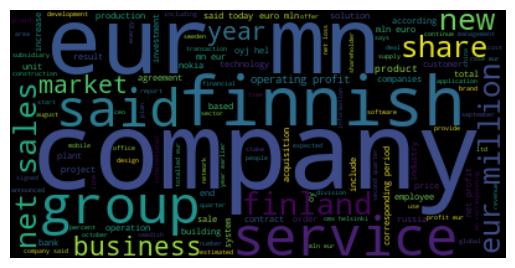

In [22]:
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis("off")
plt.show()

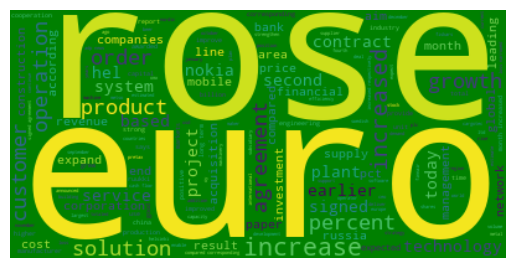

In [23]:
positive_words = df[df["label_name"] == "positive"]

positive_words.loc[:, "text"] = positive_words["text"].apply(lambda x: ' '.join(x for x in x.split() if x not in common_words))
positive_text = " ".join(i for i in positive_words.text)

wordCloud = WordCloud(background_color="green").generate(positive_text)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [24]:
positive_words.to_csv("datasets/positive_words.csv", index=False)

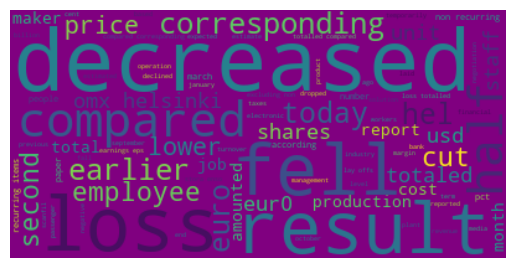

In [25]:
negative_words = df[df["label_name"] == "negative"]

negative_words.loc[:, "text"] = negative_words["text"].apply(lambda x: ' '.join(x for x in x.split() if x not in common_words))

negative_text = " ".join(i for i in negative_words["text"])

wordCloud = WordCloud(background_color="purple").generate(negative_text)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [26]:
negative_words.to_csv("datasets/negative_words.csv", index=False)

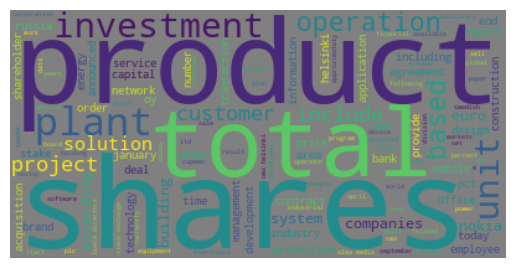

In [27]:
neutral_words = df[df["label_name"] == "neutral"]

neutral_words.loc[:, "text"] = neutral_words["text"].apply(lambda x: ' '.join(x for x in x.split() if x not in common_words))

neutral_text = " ".join(i for i in neutral_words["text"])

wordCloud = WordCloud(background_color="grey").generate(neutral_text)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [28]:
neutral_words.to_csv("datasets/neutral_words.csv", index=False)

In [29]:
raw_y = df["label_name"]
print(raw_y)

y = LabelEncoder().fit_transform(raw_y)
print(y)
df["label"] = y

0        neutral
1        neutral
2       negative
3       positive
4       positive
          ...   
4841    negative
4842     neutral
4843    negative
4844    negative
4845    negative
Name: label_name, Length: 4846, dtype: object
[1 1 0 ... 0 0 0]


In [30]:
df

,text,label_name,label
0,according gran company plans production russia...,neutral,1
1,"technopolis plans develop stages area 100,000 ...",neutral,1
2,international electronic industry company elco...,negative,0
3,new production plant company increase capacity...,positive,2
4,according company updated strategy years 2009 ...,positive,2
...,...,...,...
4841,london marketwatch -- share prices ended lower...,negative,0
4842,rinkuskiai beer sales fell 6.5 cent million li...,neutral,1
4843,operating profit fell eur 35.4 mn eur mn 2007 ...,negative,0
4844,net sales paper segment decreased eur mn secon...,negative,0


In [30]:
#df.drop(columns="label", inplace=True)

In [31]:
#df.to_csv("datasets/sentences.csv", index=False)

In [32]:
X = df["text"]

In [33]:
X_count_vectorizer = CountVectorizer()
count_matrix = X_count_vectorizer.fit_transform(X)
count_array = count_matrix.toarray()
print(count_array)

[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [34]:
joblib.dump(X_count_vectorizer, "countvectorizer.pkl")

['countvectorizer.pkl']

In [35]:
X_tfidf_word_vec = TfidfVectorizer()
X_word_tfidf = X_tfidf_word_vec.fit_transform(X)
print(X_word_tfidf.toarray())

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.17901091 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [36]:
X_tfdif_ngram_vec = TfidfVectorizer(ngram_range=(2,3))
X_ngram_tfidf = X_tfdif_ngram_vec.fit_transform(X)
print(X_ngram_tfidf)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 94959 stored elements and shape (4846, 73386)>
  Coords	Values
  (0, 4424)	0.2815010203885414
  (0, 30052)	0.2815010203885414
  (0, 14613)	0.2371197290247503
  (0, 50254)	0.2815010203885414
  (0, 52657)	0.26852032479784266
  (0, 57883)	0.2815010203885414
  (0, 14318)	0.2815010203885414
  (0, 4425)	0.2815010203885414
  (0, 30053)	0.2815010203885414
  (0, 14618)	0.2815010203885414
  (0, 50255)	0.2815010203885414
  (0, 52658)	0.2815010203885414
  (0, 57884)	0.2815010203885414
  (1, 67278)	0.169184066302116
  (1, 50225)	0.17736269063946453
  (1, 19597)	0.17736269063946453
  (1, 63962)	0.17736269063946453
  (1, 7296)	0.17736269063946453
  (1, 356)	0.15209324698530938
  (1, 128)	0.14297626883048795
  (1, 63814)	0.15209324698530938
  (1, 41419)	0.17736269063946453
  (1, 47137)	0.17736269063946453
  (1, 32237)	0.17736269063946453
  (1, 13954)	0.17736269063946453
  :	:
  (4844, 59146)	0.1639015425095541
  (4844, 48432)	0.163901542509

In [37]:
count_vec_log = LogisticRegression().fit(count_array,y)

cross_val_score(count_vec_log,
                count_array,
                y,
                scoring="accuracy",
                cv=5).mean()

np.float64(0.6894290000319172)

In [38]:
count_vec_log = LogisticRegression().fit(count_array,y)

cross_val_score(count_vec_log,
                count_array,
                y,
                scoring="f1_macro",
                cv=5).mean()

np.float64(0.5713995101610407)

In [39]:
count_vec_model = XGBRFClassifier()

count_vec_model.fit(count_matrix,y)

cross_val_score(count_vec_model,
                count_array,
                y,
                scoring="accuracy",
                cv=5).mean()

np.float64(0.6529007479280372)

In [40]:
count_vec_model = XGBRFClassifier()

count_vec_model.fit(count_matrix,y)

cross_val_score(count_vec_model,
                count_array,
                y,
                scoring="f1_macro",
                cv=5).mean()

np.float64(0.4449512579010527)

In [41]:
tfdif_word_log_model = LogisticRegression().fit(X_word_tfidf, y)

cross_val_score(tfdif_word_log_model,
                X_word_tfidf,
                y,
                scoring="accuracy",
                cv=5).mean()

np.float64(0.6869483897737065)

In [42]:
tfdif_word_log_model = LogisticRegression().fit(X_word_tfidf, y)

cross_val_score(tfdif_word_log_model,
                X_word_tfidf,
                y,
                scoring="f1_macro",
                cv=5).mean()

np.float64(0.5165236281904403)

In [43]:
tfidf_word_xgb_model = XGBRFClassifier().fit(X_word_tfidf,y)

cross_val_score(tfidf_word_xgb_model,
                X_word_tfidf,
                y,
                scoring="accuracy",
                cv=5).mean()

np.float64(0.6485706382390178)

In [44]:
tfidf_word_xgb_model = XGBRFClassifier().fit(X_word_tfidf,y)

cross_val_score(tfidf_word_xgb_model,
                X_word_tfidf,
                y,
                scoring="f1_macro",
                cv=5).mean()

np.float64(0.44014832875145055)

In [45]:
tfidf_ngram_log_model = LogisticRegression().fit(X_ngram_tfidf, y)

cross_val_score(tfidf_ngram_log_model,
                X_ngram_tfidf,
                y,
                scoring="accuracy",
                cv=5).mean()

np.float64(0.6118417328950029)

In [46]:
tfidf_ngram_log_model = LogisticRegression().fit(X_ngram_tfidf, y)

cross_val_score(tfidf_ngram_log_model,
                X_ngram_tfidf,
                y,
                scoring="f1_macro",
                cv=5).mean()

np.float64(0.32363489813410695)

In [47]:
tfidf_ngram_xgb_model = XGBRFClassifier().fit(X_ngram_tfidf,y)

cross_val_score(tfidf_ngram_xgb_model,
                X_ngram_tfidf,
                y,
                scoring="accuracy",
                cv=5).mean()

np.float64(0.6042083984977604)

In [48]:
tfidf_ngram_xgb_model = XGBRFClassifier().fit(X_ngram_tfidf,y)

cross_val_score(tfidf_ngram_xgb_model,
                X_ngram_tfidf,
                y,
                scoring="f1_macro",
                cv=5).mean()

np.float64(0.3288993435782663)

In [49]:
def objective(trial):
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga'])
    c = trial.suggest_loguniform('C', 1e-5, 1e2)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    tol = trial.suggest_loguniform('tol', 1e-5, 1e-2)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])

    
    model = LogisticRegression(
        C=c,
        penalty='l2',
        solver=solver,
        max_iter=max_iter,
        tol=tol,
        fit_intercept=fit_intercept,
        class_weight='balanced'
    )

    score = cross_val_score(model, count_array, y, scoring="accuracy", cv=5).mean()

    return score

In [50]:
study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=50)

[I 2024-11-08 16:22:15,848] A new study created in memory with name: no-name-a789129b-2974-4d4b-843f-b91dc6e736c2
C:\Users\MEHMET\AppData\Local\Temp\ipykernel_12312\2463944703.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  c = trial.suggest_loguniform('C', 1e-5, 1e2)
C:\Users\MEHMET\AppData\Local\Temp\ipykernel_12312\2463944703.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  tol = trial.suggest_loguniform('tol', 1e-5, 1e-2)
[I 2024-11-08 16:22:19,701] Trial 0 finished with value: 0.6399068015703298 and parameters: {'solver': 'lbfgs', 'C': 2.281158283573619, 'max_iter': 841, 'tol': 0.0008860071907201189, 'fit_intercept': False}. Best is trial 0 with value: 0.639

In [51]:
print("Best Score:", study.best_value)
print("Best Hyperparameters:", study.best_params)

Best Score: 0.6916981051780452
Best Hyperparameters: {'solver': 'liblinear', 'C': 0.47391135829563474, 'max_iter': 710, 'tol': 0.002021306165835778, 'fit_intercept': True}


In [52]:
def objective(trial):
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga'])
    c = trial.suggest_loguniform('C', 1e-5, 1e2)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    tol = trial.suggest_loguniform('tol', 1e-5, 1e-2)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])

    
    model = LogisticRegression(
        C=c,
        penalty='l2',
        solver=solver,
        max_iter=max_iter,
        tol=tol,
        fit_intercept=fit_intercept,
        class_weight='balanced'
    )

    score = cross_val_score(model, count_array, y, scoring="f1_macro", cv=5).mean()

    return score

In [53]:
study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=50)

[I 2024-11-08 16:27:44,644] A new study created in memory with name: no-name-32116570-118b-46c4-8ad8-79dee7d222b7
C:\Users\MEHMET\AppData\Local\Temp\ipykernel_12312\2901439615.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  c = trial.suggest_loguniform('C', 1e-5, 1e2)
C:\Users\MEHMET\AppData\Local\Temp\ipykernel_12312\2901439615.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  tol = trial.suggest_loguniform('tol', 1e-5, 1e-2)
[I 2024-11-08 16:27:45,424] Trial 0 finished with value: 0.3377347845003992 and parameters: {'solver': 'liblinear', 'C': 4.4840693409592736e-05, 'max_iter': 233, 'tol': 2.1998397258392755e-05, 'fit_intercept': True}. Best is trial 0 with val

In [54]:
print("Best Score:", study.best_value)
print("Best Hyperparameters:", study.best_params)

Best Score: 0.5937110479735423
Best Hyperparameters: {'solver': 'lbfgs', 'C': 0.6237985633609497, 'max_iter': 567, 'tol': 0.004544735029814246, 'fit_intercept': True}


In [55]:
best_params = study.best_trial.params
best_model = LogisticRegression(**best_params, class_weight="balanced")
best_model.fit(count_array, y)

LogisticRegression(C=0.6237985633609497, class_weight='balanced', max_iter=567,
                   tol=0.004544735029814246)

In [56]:
with open("best_logistic_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [57]:
data = {
    "text": [
        # Positive sentences
        "The stock price surged by 15% following the positive earnings report.",
        "Investors are optimistic as the company’s revenue growth exceeded expectations.",
        "The acquisition has strengthened the company’s position in the market.",
        "The CEO’s guidance for the next quarter was well-received by analysts.",
        "Strong quarterly profits have boosted investor confidence in the company’s future.",

        # Neutral sentences
        "The company announced a new product line to enter a different segment.",
        "Quarterly results were in line with market expectations, with no major surprises.",
        "The stock traded within a narrow range throughout the day.",
        "The board approved a minor adjustment to the current fiscal policy.",
        "The company has plans to expand internationally over the next few years.",

        # Negative sentences
        "The company’s earnings fell short of analysts' expectations, causing concern.",
        "The stock dropped by 10% amid disappointing revenue figures.",
        "Several top executives resigned amid ongoing internal issues.",
        "The firm faces regulatory challenges that may impact its growth potential.",
        "Rising debt levels have raised worries among investors about future stability."
    ],
    "label": [
        "positive", "positive", "positive", "positive", "positive",
        "neutral", "neutral", "neutral", "neutral", "neutral",
        "negative", "negative", "negative", "negative", "negative"
    ]
}

t_df = pd.DataFrame(data)
t_df

,text,label
0,The stock price surged by 15% following the po...,positive
1,Investors are optimistic as the company’s reve...,positive
2,The acquisition has strengthened the company’s...,positive
3,The CEO’s guidance for the next quarter was we...,positive
4,Strong quarterly profits have boosted investor...,positive
5,The company announced a new product line to en...,neutral
6,Quarterly results were in line with market exp...,neutral
7,The stock traded within a narrow range through...,neutral
8,The board approved a minor adjustment to the c...,neutral
9,The company has plans to expand internationall...,neutral


In [58]:
t_df["text"] = t_df["text"].str.lower()

In [59]:
t_df["text"] = t_df["text"].apply(lambda x: re.sub(r"(?<!\d)[.,;:](?!\d)", "", x)) 
t_df["text"] = t_df["text"].apply(lambda x: re.sub(r"\b(\d+(\.\d+)?%?)\b", r"\1", x)) 

In [60]:
t_df["text"] = t_df["text"].apply(lambda x:
                               " ".join([word.text for word in nlp(x) 
                                         if word.text.lower() not in stopWords]))

In [61]:
t_df["text"] = t_df["text"].str.strip()

t_df["text"] = t_df["text"].str.replace(r"\s+", " ", regex=True)

In [62]:
y_test = t_df["label"]

y_test = LabelEncoder().fit_transform(y_test)

print(y_test)

[2 2 2 2 2 1 1 1 1 1 0 0 0 0 0]


In [63]:
X_test_count = X_count_vectorizer.transform(t_df["text"])

In [64]:
best_model.predict(X_test_count)

array([2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 0, 0, 1, 1, 2])

In [65]:
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = smote.fit_resample(count_array,y)

In [66]:
best_model.fit(X_resampled, y_resampled)

LogisticRegression(C=0.6237985633609497, class_weight='balanced', max_iter=567,
                   tol=0.004544735029814246)

In [67]:
best_model.predict(X_test_count)

array([2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 0, 0, 0, 2, 2])

In [68]:
with open("smote_logistic_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [69]:
undersampler = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(count_array, y)

In [70]:
best_model.fit(X_resampled, y_resampled)

LogisticRegression(C=0.6237985633609497, class_weight='balanced', max_iter=567,
                   tol=0.004544735029814246)

In [71]:
best_model.predict(X_test_count)

array([2, 1, 1, 0, 2, 2, 1, 1, 2, 2, 0, 0, 1, 1, 2])

In [72]:
with open("under_sample_logistic_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [73]:
with open("best_logistic_model.pkl", "rb") as f:
    loaded_log_model = pickle.load(f)

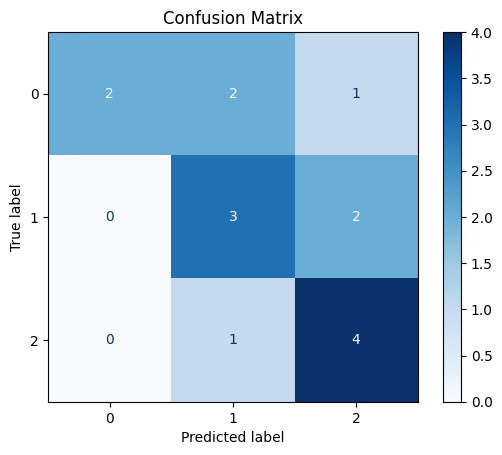

In [74]:
y_pred = loaded_log_model.predict(X_test_count)
y_true = y_test

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=loaded_log_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

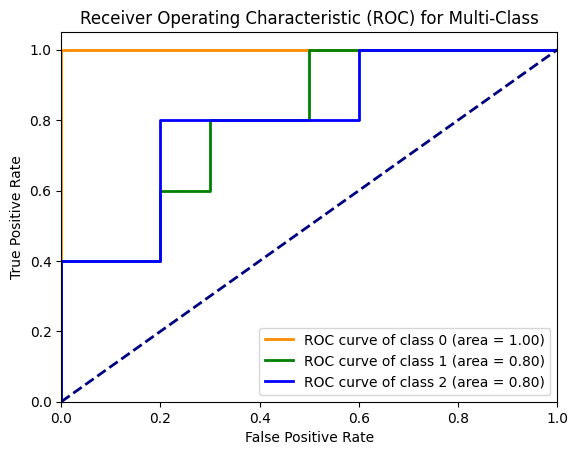

In [75]:
n_classes = 3


y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])


y_score = loaded_log_model.predict_proba(X_test_count)


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
colors = ['darkorange', 'green', 'blue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multi-Class')
plt.legend(loc="lower right")
plt.show()

In [76]:
y_pred = loaded_log_model.predict(X_test_count)

print(classification_report(y_test, y_pred, target_names=['Class Negative', 'Class Neutral', 'Class Positive']))

                precision    recall  f1-score   support

Class Negative       1.00      0.40      0.57         5
 Class Neutral       0.50      0.60      0.55         5
Class Positive       0.57      0.80      0.67         5

      accuracy                           0.60        15
     macro avg       0.69      0.60      0.59        15
  weighted avg       0.69      0.60      0.59        15



In [77]:
with open("smote_logistic_model.pkl", "rb") as f:
    loaded_smote_model = pickle.load(f)

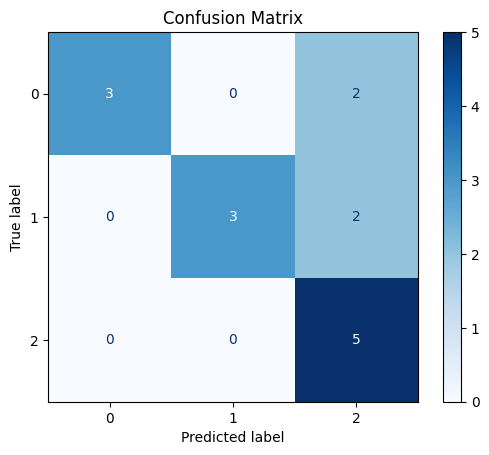

In [78]:
y_pred = loaded_smote_model.predict(X_test_count)
y_true = y_test

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=loaded_smote_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

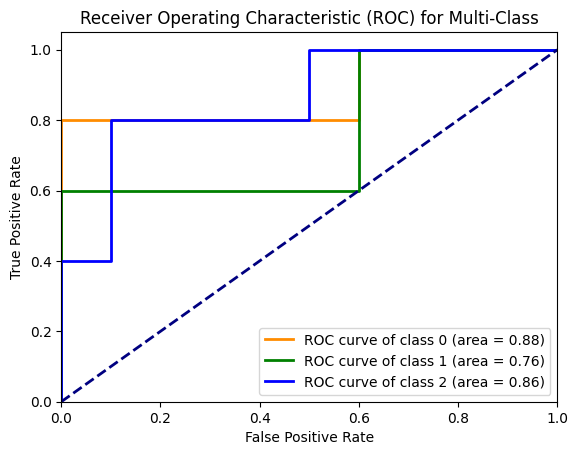

In [79]:
n_classes = 3


y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])


y_score = loaded_smote_model.predict_proba(X_test_count)


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
colors = ['darkorange', 'green', 'blue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multi-Class')
plt.legend(loc="lower right")
plt.show()

In [80]:
y_pred = loaded_smote_model.predict(X_test_count)

print(classification_report(y_test, y_pred, target_names=['Class Negative', 'Class Neutral', 'Class Positive']))

                precision    recall  f1-score   support

Class Negative       1.00      0.60      0.75         5
 Class Neutral       1.00      0.60      0.75         5
Class Positive       0.56      1.00      0.71         5

      accuracy                           0.73        15
     macro avg       0.85      0.73      0.74        15
  weighted avg       0.85      0.73      0.74        15



In [81]:
with open("under_sample_logistic_model.pkl", "rb") as f:
    loaded_under_sample_model = pickle.load(f)

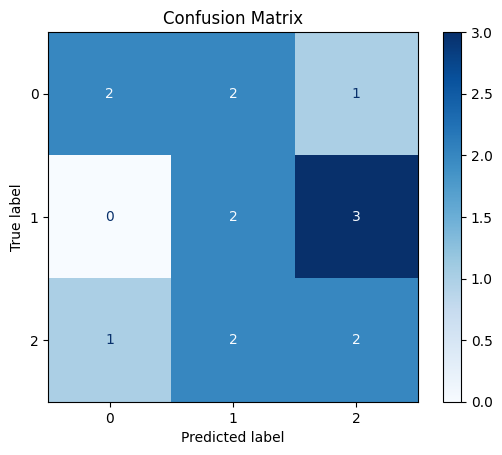

In [82]:
y_pred = loaded_under_sample_model.predict(X_test_count)
y_true = y_test

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=loaded_under_sample_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

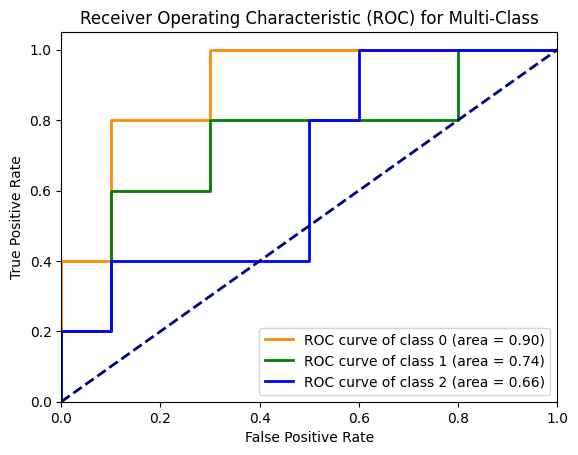

In [83]:
n_classes = 3


y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])


y_score = loaded_under_sample_model.predict_proba(X_test_count)


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
colors = ['darkorange', 'green', 'blue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multi-Class')
plt.legend(loc="lower right")
plt.show()

In [84]:
y_pred = loaded_under_sample_model.predict(X_test_count)

print(classification_report(y_test, y_pred, target_names=['Class Negative', 'Class Neutral', 'Class Positive']))

                precision    recall  f1-score   support

Class Negative       0.67      0.40      0.50         5
 Class Neutral       0.33      0.40      0.36         5
Class Positive       0.33      0.40      0.36         5

      accuracy                           0.40        15
     macro avg       0.44      0.40      0.41        15
  weighted avg       0.44      0.40      0.41        15

